In [1]:
import numpy as np
from read_code import read_code
import matplotlib.pyplot as plt
import galois
from pymatching import Matching
# https://www.mathworks.com/help/comm/ref/gen2par.html

In [2]:
def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))


In [3]:
def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)
    

def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break
        
        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)
    
    return (logicals, generators)

In [4]:
params, H = read_code('./codes/5_4_360.txt')

n = H.shape[1]
m = H.shape[0]
m1 = params['m1']
m2 = params['m2']
Hx = H[:m1]
Hz = H[m1:]

Gx, col_Gx = par2gen(Hx)
Gz, col_Gz = par2gen(Hz)
logicals, generators = SGSOP(Gx, Gz, n)

print(f"[[{n},{len(logicals)}]]")

[[360,38]]


In [4]:
def num_decoding_failures_vectorised(H, logicals, p, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < p).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

def num_decoding_failures_vectorised_masked(H, logicals, p, p_mask, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)

    num_errors = 0
    for i in range(num_shots):
        mask = np.where(np.random.random(H.shape[0]) < p_mask)[0]
        matching.set_boundary_nodes(set(mask))
        noise = (np.random.random(H.shape[1]) < p).astype(np.uint8)
        shots = (noise @ H.T) % 2
        shots[mask] = 0
        actual_observables = (noise @ logicals.T) % 2
        predicted_observables = matching.decode(shots)
        num_errors += np.sum(np.any(predicted_observables != actual_observables))
    return num_errors

def num_decoding_failures_iterative(H, logicals, p, p_mask, num_shots, T):
    unmasked_matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    masked_matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p))

    num_errors = 0
    for i in range(num_shots):
        noise = np.zeros(H.shape[1], dtype=np.uint8)
        mask = np.where(np.random.random(H.shape[0]) < p_mask)[0]
        masked_matching.set_boundary_nodes(set(mask))

        for j in range(T):
            noise = noise ^ (np.random.random(H.shape[1]) < p).astype(np.uint8)
            shots = (noise @ H.T) % 2
            shots[mask] = 0
            # actual_observables = (noise @ logicals.T) % 2
            predicted_error = masked_matching.decode(shots)
            noise = noise ^ predicted_error

        noise = noise ^ (np.random.random(H.shape[1]) < p).astype(np.uint8)
        shots = (noise @ H.T) % 2
        actual_observables = (noise @ logicals.T) % 2
        predicted_observables = unmasked_matching.decode(shots)
        num_errors += np.sum(np.any(predicted_observables != actual_observables))
        
    return num_errors

In [5]:
num_shots = 2000
ps = np.linspace(0.0001, 0.02, 20)
Ts = np.linspace(1,50,11,dtype=np.uint8)
np.random.seed(2)
log_errors_all_L = []

codes = [
    "./codes/5_4_60.txt",
    "./codes/5_4_160.txt",
    # "./codes/5_4_360.txt",
    # "./codes/5_4_660.txt"
]

for code in codes:
    print(f"Simulating {code}")
    params, H = read_code(code)

    n = H.shape[1]
    m = H.shape[0]
    m1 = params['m1']
    m2 = params['m2']
    Hx = H[:m1]
    Hz = H[m1:]

    Gx, col_Gx = par2gen(Hx)
    Gz, col_Gz = par2gen(Hz)
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])
    log_errors = []
    for T in Ts:
        # num_errors = num_decoding_failures_vectorised(Hz, logZ, p, num_shots)
        # num_errors += num_decoding_failures_vectorised(Hx, logX, p, num_shots)
        num_errors = num_decoding_failures_iterative(Hx, logX, 0.001, 0.2, num_shots, T)
        num_errors += num_decoding_failures_iterative(Hz, logZ, 0.001, 0.2, num_shots, T)

        log_errors.append(num_errors/(2*num_shots))
    log_errors_all_L.append(np.array(log_errors))

Simulating ./codes/5_4_60.txt
Simulating ./codes/5_4_160.txt


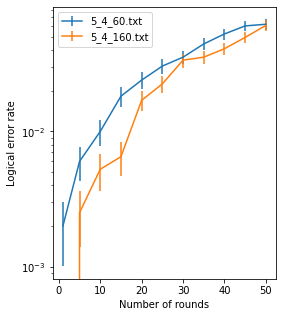

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,5))


for code, logical_errors in zip(codes, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    ax.errorbar(Ts, logical_errors, yerr=std_err, label="{}".format(code.split("/")[2]))
ax.set_xlabel("Number of rounds")
ax.set_ylabel("Logical error rate")
plt.legend(loc=0)
plt.yscale('log')

In [44]:
log_errors_all_L

[array([0.000625, 0.0025  , 0.003625, 0.005375, 0.006625, 0.010375,
        0.0125  , 0.01375 , 0.015375, 0.017   , 0.021125]),
 array([0.      , 0.0005  , 0.001375, 0.00125 , 0.0025  , 0.00375 ,
        0.005375, 0.006   , 0.008375, 0.011   , 0.009125])]

In [93]:
p_mask = 0.1
p = 0.05
params, H = read_code("./codes/5_4_60.txt")

n = H.shape[1]
m = H.shape[0]
m1 = params['m1']
m2 = params['m2']
Hx = H[:m1]
Hz = H[m1:]

Gx, col_Gx = par2gen(Hx)
Gz, col_Gz = par2gen(Hz)
logicals, generators = SGSOP(Gx, Gz, n)

logX = np.array([l[1][n:] for l in logicals])
logZ = np.array([l[0][:n] for l in logicals])

unmasked_matching = Matching.from_check_matrix(Hx, weights=np.log((1-p)/p), faults_matrix=logX)

# mask = np.where(np.random.random(Hx.shape[0]) < p_mask)[0]
# matching.set_boundary_nodes(set(mask))
noise = (np.random.random(Hx.shape[1]) < p).astype(np.uint8)
shots = (noise @ Hx.T) % 2
# shots[mask] = 0
actual_observables = (noise @ logX.T) % 2
predicted_observables = matching.decode(shots)